# Dados

Os dados utilizados neste notebook podem ser encontrados em https://drive.google.com/drive/u/1/folders/0ALqN9KkemfmvUk9PVA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as image
from time import time
import imageio as io
import random
import pandas as pd
from sklearn.neural_network import MLPRegressor


# Funções:

In [58]:
def sigmoid(x, y, b, val):    #Função de ativação usada para avaliar a rede

    z = np.dot(y, x)
    
    if val:
        z = z.transpose() + b
    else:
        z += b

    a = (1/(1+np.exp(-z)))
            
    #a = np.array(a)

    return a, z

def softmax(x, y, b, val):

    z = np.dot(y, x)
    
    if val:
        output = []
        z = z.transpose() + b
        for exp in np.exp(z):
            output.append(exp / np.sum(exp))
        np.array(output)
    else:
        z += b
        exp = np.exp(z)
        output = exp / np.sum(exp)

    return output, z

def tanh(x, y, b):
    z = np.dot(y, x) + b
    a = []
    for h in z:
        if h >= 700:
            a.append(1)

        elif h <= -700:
            a.append(0)

        else:
            a.append(np.tanh(h))
            
    a = np.array(a)

    return a, z

def derivate_sigmoid(X):  #Derivada da função de ativação

    exp = np.exp(-X)
    
    der = (1/(1 + exp) * (1 - 1/(1 + exp)))

                       
    return der


def derivate_tanh(X):  #Derivada da função de ativação
    der = []
    for x in X:
        
        if x < 700 and x > -700:   # Condição usada para não dar erro, mas espera-se que os valores nunca estejam fora desse intervalo, já que o neurônio ficaria saturado
            der.append(1-np.tanh(x)**2)
                       
        else:
            der.append(0)
                       
    return np.array(der)




class Network():
    def __init__(self, architecture):   # Aqui, serão iniciados aleatóriamente os parâmetros da rede, conforme estrutura informada em "architeture"
        self.architecture = architecture
        self.w = []
        self.b = []
        for i in np.arange(1,len(architecture)):
            self.w.append([])
            self.b.append([])
            for j in range(architecture[i]):
                self.b[i-1].append(np.random.normal(0,1))
                self.w[i-1].append([])
                for k in range(architecture[i-1]):
                    self.w[i-1][j].append(np.random.normal(0,1/np.sqrt(architecture[i-1])))  # Este desvio padrão é usado para previnir que os neurônios estejam saturados no começo
            self.w[i-1] = np.array(self.w[i-1])
            self.b[i-1] = np.array(self.b[i-1])
            
    def cost_function(self, x, y):    # x -> output; y -> input 
        C = 0
        n = len(y)
        a, trash = self.evaluate_2(np.array(x))
        a = a[-1]
        
        C += np.sum((np.array(y) - np.array(a))**2)/n #-np.sum(np.array(y) * np.log(np.array(a)))/n
                #C += -(x[i][j] * np.log(a[j]) + (1-x[i][j]) * np.log(1-a[j]))/n

        return C
    
    def cost_function_g(self, x, y):    # x -> output; y -> input 
        C = 0
        n = len(y)
        a, trash = self.evaluate_2(np.array(x))
        a = a[-1]
        
        C += np.sum(np.abs(np.array(y) - np.array(a)))/n #-np.sum(np.array(y) * np.log(np.array(a)))/n
                #C += -(x[i][j] * np.log(a[j]) + (1-x[i][j]) * np.log(1-a[j]))/n

        return C


    def evaluate(self, y):      # Avalia a rede neural
        a = [y]
        z = []
        for i in range(len(self.w)):
            
            if i == len(self.w) - 1:
                vec_aux = softmax(a[i], self.w[i], self.b[i], False)
            else:
                vec_aux = sigmoid(a[i], self.w[i], self.b[i], False)
                
            z.append(vec_aux[1])                  
            a.append(vec_aux[0])

            
        return a, z                # A saída mais importante é o "a", mas o "z" foi acrescentado aqui em uma tentativa de otimização
    
    
    def evaluate_2(self, y):      # Avalia a rede neural
        a = [y]
        z = []
        for i in range(len(self.w)):
            
            if i == len(self.w) - 1:
                vec_aux = softmax(a[i].transpose(), self.w[i], self.b[i], True)
            else:
                vec_aux = sigmoid(a[i].transpose(), self.w[i], self.b[i], True)
                
            z.append(vec_aux[1])                  
            a.append(vec_aux[0])

            
        return a, z               


    def update(self, y, x, eta9, nu):           # Função usada para atualizar os pesos, W's, e bias, b's 
        
        eta = -eta9  # Learning rate
        
        #dw, db = derivative(y, self, x, self.w, self.b)
        
        #------------------------------------------------------------------------------------------------
        
        n = len(y)


        dw = []
        db = []
        
        for i in range(len(self.w)):
            dw.append(0)
            db.append(0)

        a, z = self.evaluate_2(np.array(y))  # Avalia os dados de entrada na rede e devolve os dados de saída, "a", e o "z", que é usado no processo de avaliação    
                
        for l in range(n): #while l < n:           
            
            for i in range(len(self.w)):   # Rodando em todas as camadas da rede
                
                i = len(self.w) - i - 1    # O algorítmo do 'Back Propagation' começa no fim e termina no começo
                
                da_aux = 0


                d_sigma = derivate_sigmoid(z[i][l]) 

  
                '''
                ---------------------------------------------------------------------------------------------------------------------
                Aqui é calculado a derivada da função de custo em relação aos a's - matriz representando a saída de cada neurônio da rede
                
                '''

                if i == len(self.w) - 1 :
                    
                    da_aux = np.dot(a[i + 1][l] - x[l], self.w[i])
                        
                else:
                    
                    da_aux = np.dot(da * d_sigma, self.w[i])
                    
                '''
                ---------------------------------------------------------------------------------------------------------------------
                Aqui é calculado a derivada da função de custo em relação aos w's - pesos dos neurônios
                
                '''
                        

                if i == len(self.w) - 1 :
                    
                    dw_aux = np.outer(a[i + 1][l] - x[l], a[i][l]) + nu * self.w[i]

                else:
                    
                    dw_aux = np.outer(da * d_sigma, a[i][l]) + nu * self.w[i] 
                    
                '''
                ---------------------------------------------------------------------------------------------------------------------
                Aqui é calculado a derivada da função de custo em relação aos b's
                
                '''

                if i == len(self.w) - 1:              

                    db_aux = a[i + 1][l] - x[l]           

                else:      
                    db_aux = da * d_sigma
                    
                # O resultado é, então, acresentado em dw e db, representando a derivada total na época em questão

                dw[i] += eta * np.array(dw_aux)
                db[i] += eta * np.array(db_aux)
                da = da_aux
  
        #------------------------------------------------------------------------------------------------
            
        for m in range(len(self.w)):   # Os w's e b's são atualizados
            
            self.w[m] += dw[m] / n
            self.b[m] += db[m] / n

                    
        return None
    
    def run_epoch(self, times_interaction, Training_input, training_output):    
        eta = 1                     # Taxa de aprendizagem (Learning rate)
        nu = 0.0005                    # Regularização
        graph = False              # Informa se será plotado gráficos da função de custo
        minibatch = 200            # length of the minibatch. If 0, all the integer batch is going to be used

        if minibatch != 0:    # Necessário para fazer o random choice
            dataset = {}
            dataset['input'] = Training_input
            dataset['output'] = training_output
            dataset = pd.DataFrame(dataset)
            index = np.arange(0,len(Training_input)).tolist()

        if graph:             # Dados para o ponto de interação zero do gráfico

            Training_cost = [self.cost_function(training_output, Training_input)]       
            Validation_cost = [self.cost_function(validation_output, validation_input)]

        start = time()
        for i in range(times_interaction):

            if minibatch != 0:  #Random choice do minibatch

                chose_index = random.sample(index, minibatch)
                Training_input_aux = dataset.loc[chose_index, 'input'].values.tolist()
                training_output_aux = dataset.loc[chose_index, 'output'].values.tolist()
                self.update(Training_input_aux, training_output_aux, eta, nu)

            else:    

                self.update(Training_input, training_output, eta, nu)

            if graph:
                Training_cost.append(self.cost_function(training_output, Training_input))
                Validation_cost.append(self.cost_function(validation_output, validation_input))

            if i == 0:           # Informa o tempo que levará para acabar
                stop = time()
                print(str(-start * times_interaction/3600 + stop * times_interaction/3600) + 'h para finalizar')


        if times_interaction > 0 and graph:
            t = np.arange(0, times_interaction+1)
            plt.plot(t, Training_cost, '.', label = 'Training')
            plt.plot(t, Validation_cost, '.', label = 'Validation')
            plt.xlabel('Learning Interaction')
            plt.ylabel('Cost Function')
            plt.title('Cost Function Evolution')
            plt.legend()
            plt.show()
        return None

def interpretation(y, x):
    t = 0
    length = abs(y[0] - 1)
    for b in range(len(y)):
        if abs(y[b] - 1) < length:
            t = b
            length = abs(y[b] - 1)
            
    k = np.zeros(10)
    k[t] = 1
    aux = 1
    for i in range(len(x)):
        if x[i] != k[i]:
            aux = 0
        
    return aux
        
def test(net, validation_input, validation_output):
    cont = 0
    result_output, trash = net.evaluate_2(np.array(validation_input))
    for i in range(len(validation_input)):
        
        test = interpretation(result_output[-1][i], validation_output[i])

        if test:
            cont += 1
    return cont/len(validation_output)*100

def saving(net):
    for i in range(len(net.w)):
        file = open(str(i) + '.txt', 'w')
        for j in range(len(net.w[i])):
            for k in range(len(net.w[i][j])):
                file.write(str(net.w[i][j][k]) + ';')
            file.write('\n')




        file.close()
    file = open('b' + '.txt', 'w')
    for i in range(len(net.b)):
        for j in range(len(net.b[i])):
            file.write(str(net.b[i][j]) + ';')
        file.write('\n')
    file.close()
    
    return None

def recovering(net):
    for i in range(len(net.w)):
        file = open(str(i) + '.txt', 'r')
        line = file.readline()
        j = 0
        while line != '':
            aux = ''
            k = 0
            for c in line:
                if c != ';' and c != '\n':
                    aux += c
                elif c != '\n':
                    net.w[i][j][k] = float(aux)
                    aux = ''
                    k += 1
            j += 1
            line = file.readline()


    file = open('b' + '.txt', 'r')
    line = file.readline()
    i = 0
    while line != '':
        aux = ''
        j = 0
        for c in line:
            if c != ';' and c != '\n':
                aux += c
            elif c != '\n':
                net.b[i][j] = float(aux)
                aux = ''
                j += 1
        i += 1
        line = file.readline()
    return None



* Carregando arquivos teste 0

In [68]:
training_output = []
Training_input = []
for i in range(10000):
    training_output.append([0])
    Training_input.append([1])
validation_output = []
validation_input = []
for i in range(1000):
    validation_output.append([0])
    validation_input.append([1])
    
net = Network([1])

* Carregando arquivos do teste 1

In [126]:
path = os.getcwd()
path = os.path.join(path, 'Data')
path = os.path.join(path, 'data.txt')
file = open(path, 'r')
text = file.readline()
y = []
x = []
while text != '':
    if len(text) == 1025:
        y.append([])
        for i in text:
            if i != '\n':
                y[-1].append(int(i))
    else:

        x.append(np.zeros(10))
        n = int(text)
        x[-1][n] = 1
      
    text = file.readline()
   
file.close()
net = Network([len(y[0]), 30, 10])

Training_input = y[:946-94]
validation_input = y[946-94:]
training_output = x[:946-94]
validation_output = x[946-94:]

* Carregando arquivos do teste 2

In [3]:
path = os.getcwd()
Training_input = []
training_output = []
path = os.path.join(path, 'Data')
path = os.path.join(path, 'training')

for c in os.listdir(path):
    
    path2 = os.path.join(path, c)

    for k in os.listdir(path2):
        
        im = io.imread(path2 +'\\'+ k)
        aux = []
        
        for i in range(len(im)):
            for j in range(len(im[i])):
                aux.append(im[i][j]/255)
                
        Training_input.append(aux)
        
        training_output.append(np.zeros(10))
        training_output[-1][int(c)] = 1
        
        
path = os.getcwd()
path = os.path.join(path, 'Data')
path = os.path.join(path, 'testing')
validation_input = []
validation_output = []


for c in os.listdir(path):
    
    path2 = os.path.join(path, c)

    for k in os.listdir(path2):
        
        im = io.imread(path2 +'\\'+ k)
        aux = []
        
        for i in range(len(im)):
            for j in range(len(im[i])):
                aux.append(im[i][j]/255)
                
        validation_input.append(aux)
        
        validation_output.append(np.zeros(10))
        validation_output[-1][int(c)] = 1
        
        
net = Network((len(validation_input[0]),30,10))

* Criando redes neurais para usar no algorítimo genético e ordenando-as por eficiência

In [35]:
net = Network((len(validation_input[0]),30,10))
print(net.cost_function_g(Training_input, training_output))
net.cost_function(Training_input, training_output)

1.8006507556681024


1.0468606575060877

In [59]:
nets = []
num_net = 20
testing = []
for j in range(num_net):
    nets.append(Network((len(validation_input[0]), 101, 10)))
    
    testing.append(nets[j].cost_function(Training_input, training_output))


In [60]:
testing

[0.9742809804445024,
 0.9539072083983248,
 1.0722354928234568,
 0.974366876793436,
 1.0465771893710647,
 0.9622822295892762,
 0.9822363042827432,
 0.9559495962309742,
 1.0278155214732527,
 0.9592705599409522,
 0.9650230996428402,
 1.3000842195898397,
 1.004187181313796,
 0.9574177021503224,
 0.9604177220829248,
 0.9580581479133758,
 1.0478740490922276,
 1.0770436286118112,
 1.0525351509202379,
 0.913271685369784]

In [46]:
prob = 1/np.array(testing)
prob = (prob) / np.sum(prob)
prob

array([0.27046302, 0.23013083, 0.25939653, 0.24000962])

* Genetic algorithm training


In [63]:
def mutating(net, cost):
    mutation = 0.01 * (1 - cost / 10)
    for i in range(len(net.w)):
        for j in range(len(net.w[i])):
            for k in range(len(net.w[i][j])):
                if random.random() < mutation:
                    net.w[i][j][j] = np.random.normal(net.w[i][j][j], 1/np.sqrt(len(net.w[i][j])))

    return None
            
def crossing(net_1, net_2):
    
    net = Network((len(validation_input[0]), 101, 10))
    
    
    for i in range(len(net.w)):
        #trashold_b = random.randint(0, len(net.b[i]) - 1)
        net.w[i] = (net_1.w[i] + net_2.w[i]) / 2

        net.b[i] = (net_1.b[i] + net_2.b[i]) / 2
    
    cost = net.cost_function(Training_input, training_output)
        
    mutating(net, cost)
        
        
    return net, cost
      
times_interaction = 10
num_net = len(nets)
start = time()
n = len(nets)

for j in range(times_interaction):
    prob = 1 / np.array(testing)
    prob = prob / np.sum(prob)
    nets_aux = []
    testing_aux = []
    
    for k in range(n):
        index = np.arange(0,len(nets)).tolist()
        net_1_index = np.random.choice(index, p = prob)
        net_1 = nets[net_1_index]
        index.remove(net_1_index)
        prob_aux = np.array([prob[x] for x in range(len(prob)) if x != net_1_index])
        prob_aux = prob_aux / np.sum(prob_aux)
        net_2_index = np.random.choice(index, p = prob_aux)
        net_2 = nets[net_2_index]
        net, cost = crossing(net_1, net_2)
        testing_aux.append(cost)
        nets_aux.append(net)
        
    nets = nets_aux * 1
    testing = testing_aux * 1
    
    if j == 0:
        stop = time()

        print(str((stop - start) * times_interaction / 60) + ' min para finalizar')
            


22.947999477386475 min para finalizar


* Testando o conjunto de redes

In [49]:
for j in range(len(nets)):        
    print(nets[j].cost_function(Training_input, training_output))

0.9043141470632183
0.9043141470632367
0.9043141470632428
0.9043141470632481


KeyboardInterrupt: 

In [64]:
for net in nets:        
    print(test(net, validation_input, validation_output))

11.35
11.35
11.35
11.35
11.35
11.35
13.919999999999998
11.35
10.32
12.11
10.32
11.35
11.360000000000001
11.35
11.35
11.35
11.379999999999999
11.379999999999999
11.35
9.99


* Rede Neural para treinamento individual

In [169]:
net = Network((len(validation_input[0]), 101, 10))

* Processo de trainamento e teste com rede neural doméstica

In [175]:
net.run_epoch(100, Training_input, training_output)
test(net, validation_input, validation_output)

0.005666740238666534h para finalizar


91.47

In [171]:
test(net, validation_input, validation_output)

9.8

# Trainamento e teste de dados com rede pronta






In [51]:
rna = MLPRegressor(hidden_layer_sizes = (30), verbose = False, activation = 'logistic', solver = 'sgd', alpha = 0, learning_rate = 'constant', learning_rate_init = 0.05, tol = 0.0001, max_iter = 300)
rna.fit(Training_input, training_output)

MLPRegressor(activation='logistic', alpha=0, hidden_layer_sizes=30,
             learning_rate_init=0.05, max_iter=300, solver='sgd')

In [52]:
cont = 0
for i in range(len(validation_input)):
    result_output = rna.predict([validation_input[i]])
    test = interpretation(result_output[0], validation_output[i])
    if test:
        cont += 1
print(str(cont/len(validation_output)*100) + '% de acertos')

93.89% de acertos


# Relatos

* Network with one haden layer and 28 neurons, learning rate of 0.005 and regularization parameter of 0.0001

     95.6% of success, with approximately 4500 epoches
     
     
* Network with one haden layer and 101 neurons, learning rate of 0.005 and regularization parameter of 0.0005

     96.13% of success

# Células de teste de códigos

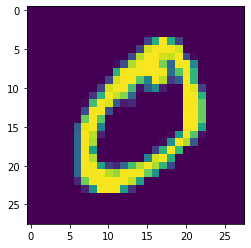

In [87]:
path = os.getcwd()
os.listdir(path)
y = []
x = []
path = os.path.join(path, 'Data')
path = os.path.join(path, 'Training')
for c in os.listdir(path):
    path2 = os.path.join(path2, 'c')
#path = os.path.join(path, os.listdir(path)[0])
    for k in os.listdir(path2):
        im = io.imread(path +'\\'+ k)
        aux = []
        for i in range(len(im)):
            for j in range(len(im[i])):
                aux.append(im[i][j])
        y.append(aux)
        x.append(np.zeros(10))
        x[-1][int(c)] = 1
plt.imshow(im)

In [35]:
a = 2.9
start = time()
for n in range(1000000):
    np.power(a, 2)
    
    
stop = time()
print(stop - start)

3.166015625


In [192]:
a = np.array([[1,2], [3,3]])
b = np.array([[1,3],[5,1]])
np.outer(a, b).transpose()

array([[ 1,  2,  3,  3],
       [ 3,  6,  9,  9],
       [ 5, 10, 15, 15],
       [ 1,  2,  3,  3]])

In [202]:
a = np.array([[1, 9],[2,11]])
b = np.array([[1, 55], [3, 48]])
a * b[0]

array([[  1, 495],
       [  2, 605]])

In [36]:
a = np.array([[1,2,5],[1,9,9], [1,9,9], [1,9,9]])
b = np.array([[1,55],[2,55], [3,55]])
c = np.array([[1,99],[2,99], [3,99]]).transpose()
d = np.array([6,0, 4])
(d*c).transpose()

array([[  6, 594],
       [  0,   0],
       [ 12, 396]])

In [53]:
import mpmath
mpmath.mp.dps = 10

In [23]:
for i in range(700000):
    if random.random() < 0.000001:
        print('.')

.
.


In [194]:
a = np.array([[1,1, 1],[2,3, 0]])
b = np.array([[2,3, 6], [1,1, 1], [2,2, 2], [0,0,0]]).transpose()
#b=np.array([1,1,1])
#np.dot(a, b).transpose()
exp_z = np.exp(a)
output = []
for exp in exp_z:
    output.append(exp / np.sum(exp))
output

[array([0.33333333, 0.33333333, 0.33333333]),
 array([0.25949646, 0.70538451, 0.03511903])]

In [47]:
o = testing/np.sum(testing)
o = (1-o)**1000/ np.sum((1-o)**1000)
o

array([0.05324408, 0.04922752, 0.04803276, 0.04208379, 0.03904111,
       0.03896629, 0.03839088, 0.0365004 , 0.03430488, 0.03322734,
       0.0329361 , 0.03101372, 0.03010722, 0.029683  , 0.02868591,
       0.02750974, 0.02400475, 0.02329676, 0.02324087, 0.02321434,
       0.0222776 , 0.02117937, 0.02092885, 0.02036603, 0.02022621,
       0.01820347, 0.0161117 , 0.01600989, 0.01519398, 0.01486297,
       0.01481072, 0.01455332, 0.0141081 , 0.0138024 , 0.01318903,
       0.01234874, 0.01209942, 0.01157714, 0.01132187, 0.01011772])

In [7]:
a = [1,2,3,35,6,8,9]
[a[x] for x in range(len(a)) if x != 2]

[1, 2, 35, 6, 8, 9]